[![Google Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/idealo/image-super-resolution/blob/master/notebooks/ISR_Prediction_Tutorial.ipynb)

# Install ISR

In [0]:
#!rm -rf ./*
#!pip install ISR

# Predict

## Get the pre-trained weights and data

(for more options on getting you data on Colab notebooks visit https://colab.research.google.com/notebooks/io.ipynb)

Get the weights with



In [1]:
!wget https://github.com/idealo/image-super-resolution/raw/master/weights/sample_weights/rdn-C6-D20-G64-G064-x2_enhanced-e219.hdf5
!wget https://github.com/idealo/image-super-resolution/raw/master/weights/sample_weights/rdn-C6-D20-G64-G064-x2_div2k-e086.hdf5
!wget https://github.com/idealo/image-super-resolution/raw/master/weights/sample_weights/rdn-C3-D10-G64-G064-x2_div2k-e134.hdf5
!mkdir weights
!mv *.hdf5 weights

--2019-03-25 10:45:56--  https://github.com/idealo/image-super-resolution/raw/master/weights/sample_weights/rdn-C6-D20-G64-G064-x2_enhanced-e219.hdf5
Loaded CA certificate '/etc/ssl/certs/ca-certificates.crt'
Resolving github.com (github.com)... 140.82.118.3, 140.82.118.4
Connecting to github.com (github.com)|140.82.118.3|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://media.githubusercontent.com/media/idealo/image-super-resolution/master/weights/sample_weights/rdn-C6-D20-G64-G064-x2_enhanced-e219.hdf5 [following]
--2019-03-25 10:45:56--  https://media.githubusercontent.com/media/idealo/image-super-resolution/master/weights/sample_weights/rdn-C6-D20-G64-G064-x2_enhanced-e219.hdf5
Resolving media.githubusercontent.com (media.githubusercontent.com)... 151.101.132.133
Connecting to media.githubusercontent.com (media.githubusercontent.com)|151.101.132.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 66071288 (63M) [applica

Download a sample image, in this case

In [7]:
#!wget http://images.math.cnrs.fr/IMG/png/section8-image.png
!wget http://www.hpca.ual.es/~vruiz/images/lena.png
#!mkdir -p data/input/test_images
#!mv *.png data/input/test_images
!cp lena.png data/input/test_images

--2019-03-25 11:29:25--  http://www.hpca.ual.es/~vruiz/images/lena.png
Resolving www.hpca.ual.es (www.hpca.ual.es)... 150.214.150.42
Connecting to www.hpca.ual.es (www.hpca.ual.es)|150.214.150.42|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 512673 (501K) [image/png]
Saving to: ‘lena.png’

lena.png            100%[===================>] 500,66K  1,54MB/s    in 0,3s    

2019-03-25 11:29:26 (1,54 MB/s) - ‘lena.png’ saved [512673/512673]



Load the image with PIL, scale it and convert it into a format our model can use (it needs the extra dimension)

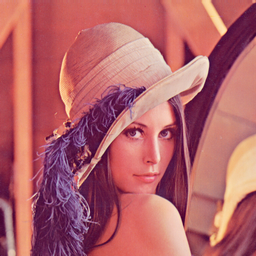

In [11]:
import numpy as np
from PIL import Image

#img = Image.open('data/input/test_images/section8-image.png')
orig = img = Image.open('data/input/test_images/lena.png')
img = img.resize((256,256), Image.ANTIALIAS)
lr_img = np.array(img)/255.
lr_img = np.expand_dims(lr_img, axis=0)

img

## Get predictions

### Create the model and run prediction
Create the RDN model, for which we provide pre-trained weights, and load them

Choose amongst the available model weights, compare the output if you wish.



In [4]:
from ISR.models import RDN

Using TensorFlow backend.


#### Large RDN model

In [9]:
rdn = RDN(arch_params={'C': 6, 'D':20, 'G':64, 'G0':64, 'x':2})
rdn.model.load_weights('weights/rdn-C6-D20-G64-G064-x2_div2k-e086.hdf5')

#### Small RDN model

In [16]:
rdn = RDN(arch_params={'C': 3, 'D':10, 'G':64, 'G0':64, 'x':2})
rdn.model.load_weights('weights/rdn-C3-D10-G64-G064-x2_div2k-e134.hdf5')

#### Large RDN noise cancelling, detail enchancing model

In [18]:
rdn = RDN(arch_params={'C': 6, 'D':20, 'G':64, 'G0':64, 'x':2})
rdn.model.load_weights('weights/rdn-C6-D20-G64-G064-x2_enhanced-e219.hdf5')

#### Run prediction

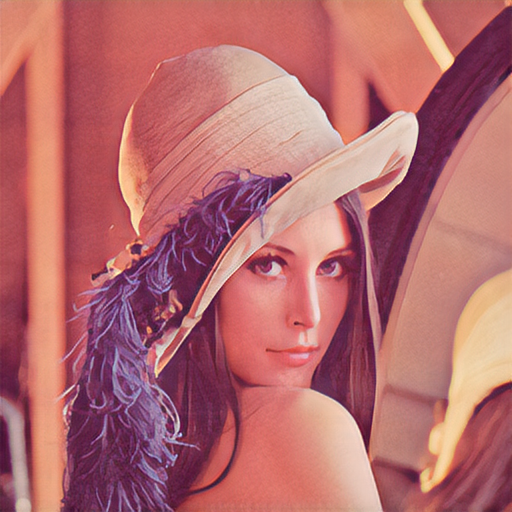

In [19]:
sr_img = rdn.model.predict(lr_img)[0]
sr_img = sr_img.clip(0, 1) * 255
sr_img = np.uint8(sr_img)
Image.fromarray(sr_img)

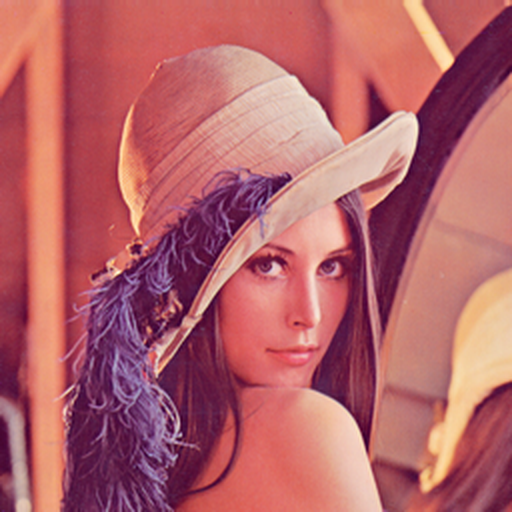

In [15]:
img.resize((512,512), Image.ANTIALIAS)

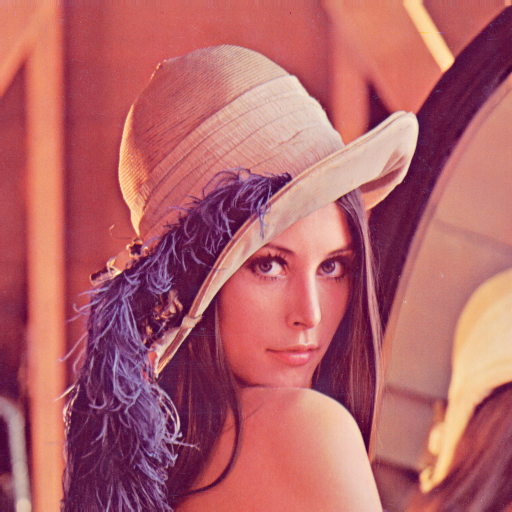

In [13]:
orig

### Usecase: upscaling noisy images

Now, for science, let's make it harder for the networks.

We compress the image into the jpeg format to introduce compression artefact and lose some information.

We will compare:
- the baseline bicubic scaling
- the basic model - Add Hyperlink
- a model trained to remove noise using perceptual loss with deep features and GANs training

So let's first  compress the image

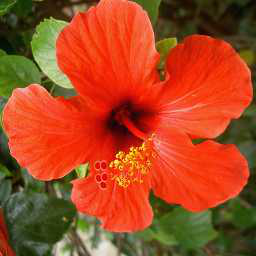

In [10]:
img.save('data/input/test_images/compressed.jpeg','JPEG', dpi=[300, 300], quality=50)
compressed_img = Image.open('data/input/test_images/compressed.jpeg')
compressed_lr_img = np.array(compressed_img)/255.
compressed_lr_img = np.expand_dims(compressed_lr_img, axis=0)

compressed_img

(open the image in a new tab and zoom in to inspect it)

#### Baseline
Bicubic scaling

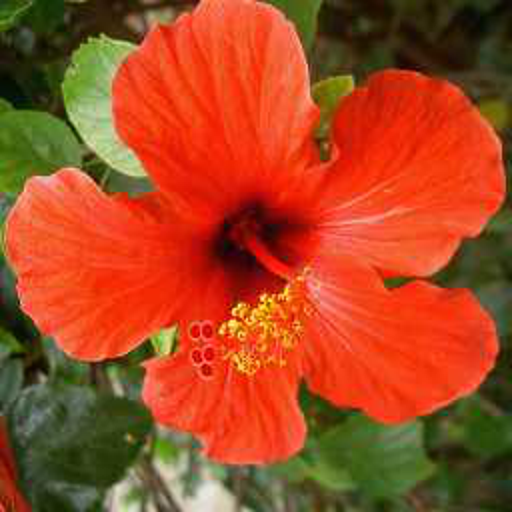

In [11]:
compressed_img.resize(size=(compressed_img.size[0]*2, compressed_img.size[1]*2), resample=Image.BICUBIC)

#### Large RDN model (PSNR trained)

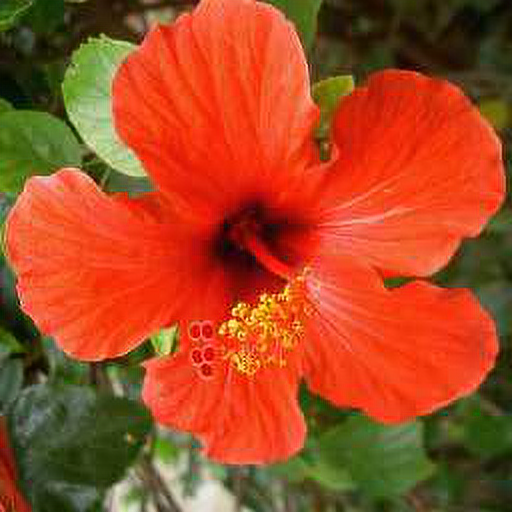

In [12]:
rdn = RDN(arch_params={'C': 6, 'D':20, 'G':64, 'G0':64, 'x':2})
rdn.model.load_weights('weights/rdn-C6-D20-G64-G064-x2_div2k-e086.hdf5')
sr_img = rdn.model.predict(compressed_lr_img)[0]
sr_img = sr_img.clip(0, 1) * 255
sr_img = np.uint8(sr_img)
Image.fromarray(sr_img)

#### Small RDN model  (PSNR trained)

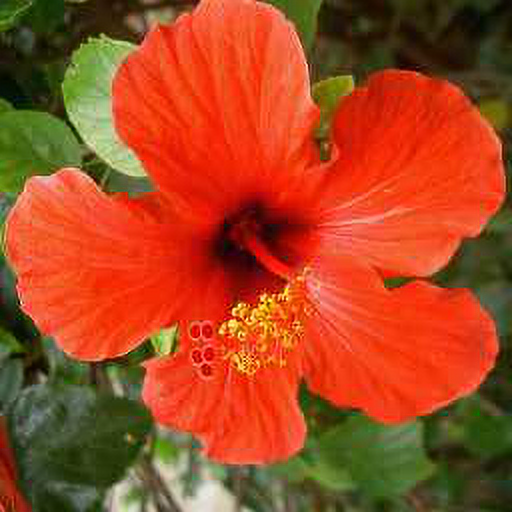

In [13]:
rdn = RDN(arch_params={'C': 3, 'D':10, 'G':64, 'G0':64, 'x':2})
rdn.model.load_weights('weights/rdn-C3-D10-G64-G064-x2_div2k-e134.hdf5')
sr_img = rdn.model.predict(compressed_lr_img)[0]
sr_img = sr_img.clip(0, 1) * 255
sr_img = np.uint8(sr_img)
Image.fromarray(sr_img)

#### Large RDN noise cancelling, detail enhancing model

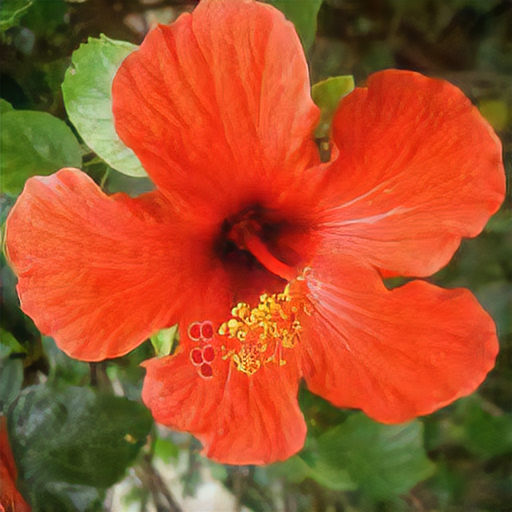

In [14]:
rdn = RDN(arch_params={'C': 6, 'D':20, 'G':64, 'G0':64, 'x':2})
rdn.model.load_weights('weights/rdn-C6-D20-G64-G064-x2_enhanced-e219.hdf5')
sr_img = rdn.model.predict(compressed_lr_img)[0]
sr_img = sr_img.clip(0, 1) * 255
sr_img = np.uint8(sr_img)
Image.fromarray(sr_img)

### Predictor Class
You can also use the predictor class to run the model on entire folders:

In [15]:
from ISR.predict.predictor import Predictor
!mkdir -p data/output
predictor = Predictor(input_dir='data/input/test_images/')
predictor.get_predictions(model=rdn, weights_path='weights/rdn-C6-D20-G64-G064-x2_enhanced-e219.hdf5')

Creating output directory:
./data/output/test_images
Loaded weights from 
 > weights/rdn-C6-D20-G64-G064-x2_enhanced-e219.hdf5
Results in:
 > ./data/output/test_images/rdn-C6-D20-G64-G064-x2/enhanced-e219
Processing file
 > data/input/test_images/compressed.jpeg
Elapsed time: 1.3935110569000244s
Result in: ./data/output/test_images/rdn-C6-D20-G64-G064-x2/enhanced-e219/compressed.jpeg
Processing file
 > data/input/test_images/section8-image.png
Elapsed time: 1.2023322582244873s
Result in: ./data/output/test_images/rdn-C6-D20-G64-G064-x2/enhanced-e219/section8-image.png
